# Capstone Project 1: In-Depth Analysis

Data source: https://www.yelp.com/dataset.

In this exploration of the yelp restaurants, we will perform predictive modeling to predict whether a restaurant is closed permanently or still open for business using an ensemble of machine learning classifiers
1. Decision Tree
2. Decision Tree Tuning
3. Logistic Regression Tuning
4. K Nearest Neighbors Tuning
5. Voting Ensemble
6. Bagging Ensemble
7. Random Forests Ensemble
8. Random Forests Tuning
9. AdaBoost Ensemble
10. Gradient Boosting Ensemble

In [26]:
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import matplotlib.pyplot as plt
import numpy as np
import random
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import mean_squared_error as MSE
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")

%store -r rests
%store -r ml

SEED = 123

In [2]:
# Get the features and label
X = ml[['special_category','change_over_time','density','volatility','review_frequency']].values #features
y = ml['is_open'].values #label

In [3]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# Train a basic decision tree classifier model with default information criterion gini
dt_gini = DecisionTreeClassifier(max_depth=2, random_state=1)
dt_gini.fit(X_train, y_train)
y_pred = dt_gini.predict(X_test)

# Print the accuracy score on the test set
accuracy_score(y_test, y_pred)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

0.7573591253153911

In [4]:
# Train the decision tree classifier model using information criterion entropy
dt_entropy = DecisionTreeClassifier(max_depth=2, criterion='entropy', random_state=1)
dt_entropy.fit(X_train, y_train)
y_pred = dt_entropy.predict(X_test)
accuracy_score(y_test, y_pred)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

0.7538898233809924

The basic decision tree classifier yields models with test accuracy scores of 0.75 and 0.76. Neither using gini nor using entropy as the information criterion provided an accurate decision tree model. We will now diagnose the bias and variance problems in order to tune the model, starting with estimating the generalization error: 
1. Split data in training and test sets
2. Cross validate the predicted function
3. Fit the predicted function to the training data
4. Fit the predicted function to the test data
4. Evaluate the MSEs

In [5]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

# Instantiate the classifier
dt_cv = DecisionTreeClassifier(max_depth=2, random_state=SEED)

# Evaluate the MSE obtained by 10-fold CV
MSE_cv = - cross_val_score(dt_cv, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error', n_jobs = -1)

# Fit the decision tree model to the training data
dt_cv.fit(X_train, y_train)

# Predict the labels of training set
y_pred_train = dt_cv.predict(X_train)

# Predict the labels of test set
y_pred_test = dt_cv.predict(X_test)

# Print the mean squared errors
print('Cross Validation MSE: {:.2f}'.format(MSE_cv.mean()))
print('Training Set MSE: {:.2f}'.format(MSE(y_train, y_pred_train)))
print('Test Set MSE: {:.2f}'.format(MSE(y_test, y_pred_test)))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

Cross Validation MSE: 0.24
Training Set MSE: 0.24
Test Set MSE: 0.24


In [6]:
# Print the MSE of the basic decision tree classifier without cross validation
print('Baseline test set MSE: {:.2f}'.format(MSE(y_test, y_pred)))

Baseline test set MSE: 0.28


The cross validation MSE is equal to the training set MSE and the test set MSE, and they are smaller than the baseline test set MSE. These metrics indicate that the cross validation decision tree model provides a good fit. Next we will try to improve the decision tree classifier by tuning its hyperparameters with RandomizedSearchCV.

In [7]:
# Tune hyperparameters in decision tree classifier using GridSearchCV
# Setup the parameters and distributions to sample from: param_grid
param_grid = {"max_depth": [2, 3, None],
              "max_features": [1,2,3,4,5],
              "min_samples_leaf": [1,2],
              "criterion": ["gini", "entropy"]}

# Instantiate the GridSearchCV object
grid_cv = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)

# Fit to training data
grid_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(grid_cv.best_params_))
print("Best score is {}".format(grid_cv.best_score_))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, None],
                         

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 2}
Best score is 0.7634282624369142


In [8]:
# Create decision tree using tuned parameters and predict on test set
dt_tuned = DecisionTreeClassifier(max_depth = 3, max_features = 4, min_samples_leaf = 1)
dt_tuned.fit(X_train, y_train)
y_pred_tuned = dt_tuned.predict(X_test)

# Print the accuracy score on the test set
accuracy_score(y_test, y_pred_tuned)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

0.7631412952060556

The accuracy of our decision tree classifier has been improved after tuning the hyperparameters.

In [9]:
# Print the mean and standard deviation of the unscaled features
print("Mean of Unscaled Features: {}".format(np.mean(X))) 
print("Standard Deviation of Unscaled Features: {}".format(np.std(X)))

Mean of Unscaled Features: 15.390587632975455
Standard Deviation of Unscaled Features: 59.44408314643911


In [10]:
# Scale the features
X_scaled = scale(X)

# Print the mean and standard deviation of the scaled features
print("Mean of Scaled Features: {}".format(np.mean(X_scaled))) 
print("Standard Deviation of Scaled Features: {}".format(np.std(X_scaled)))

Mean of Scaled Features: -3.083859463808661e-17
Standard Deviation of Scaled Features: 0.9999999999999999


In [11]:
# Build a decision tree classifier using scaled features and tuned parameters
# Split the data into training and test sets
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=SEED)

# Instantiate the decision tree
dt_scaled_tuned = DecisionTreeClassifier(max_depth = 3, max_features = 4, min_samples_leaf = 1)

# Fit the classifier to training data
dt_scaled_tuned.fit(X_scaled_train, y_train)

# Predict on test data
y_pred_scaled_tuned = dt_tuned.predict(X_scaled_test)

# Print the accuracy
accuracy_score(y_test, y_pred_scaled_tuned)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

0.7574642556770396

Scaling the features did not improve the accuracy of the decision tree prediction. Next we will tune and fit a logistic regression model.

In [12]:
# Tune hyperparameters in logistic regression classifier using GridSearchCV
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

# Instantiate the GridSearchCV object
grid_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5)

# Fit to training data
grid_lr.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(grid_lr.best_params_))
print("Best score is {}".format(grid_lr.best_score_))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])},
             pre_dispatch='2*n_jobs', refi

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795}
Best score is 0.7587418889689979


In [13]:
# Tune hyperparameters in KNN classifier using GridSearchCV
# Setup the hyperparameter grid
param_grid = {'n_neighbors': np.arange(1,50)}

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

# Instantiate the GridSearchCV object
grid_knn = GridSearchCV(KNN(), param_grid, cv=5)

# Fit to training data
grid_knn.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned KNN Parameters: {}".format(grid_knn.best_params_))
print("Best score is {}".format(grid_knn.best_score_))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Tuned KNN Parameters: {'n_neighbors': 47}
Best score is 0.7565338860850757


In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# Instantiate the classifiers
lr = LogisticRegression(C=0.44, random_state=SEED)
knn = KNN(n_neighbors=47)
dt = DecisionTreeClassifier(max_depth = 3, max_features = 4, min_samples_leaf = 1, random_state=SEED)

# Make a list of the classifiers
classifiers = [('Logistic Regression',lr),('K Nearest Neighbors',knn),('Decision Tree',dt)]

for clf_name, clf in classifiers:
    # Fit to training set
    clf.fit(X_train, y_train)
    
    # Predict the labels on the test set
    y_pred_ensemble = clf.predict(X_test)
    
    # Evaluate accuracy of the classifier on the test data
    print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))

LogisticRegression(C=0.44, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Logistic Regression : 0.754


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=47, p=2,
                     weights='uniform')

K Nearest Neighbors : 0.754


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

Decision Tree : 0.754


In [15]:
# Instantiate voting classifier
vc = VotingClassifier(estimators=classifiers)

# Fit to training data
vc.fit(X_train, y_train)

# Predict on test data
y_pred_vc = vc.predict(X_test)

# Evaluate the accuracy of voting classifier on test data
accuracy_score(y_test, y_pred_vc)

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(C=0.44, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('K Nearest Neighbors',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf...
                             ('Decision Tree',
                              DecisionTreeClas

0.7591463414634146

In [16]:
# Instantiate a decision tree with tuned parameters
dt_bag = DecisionTreeClassifier(max_depth = 3, max_features = 4, min_samples_leaf = 2, random_state=SEED)

# Instantiate a bagging classifier
bag = BaggingClassifier(base_estimator=dt_bag, n_estimators=50, n_jobs=-1)

# Fit to training set
bag.fit(X_train, y_train)

# Predict on test data
y_pred_bag = bag.predict(X_test)

# Evaluate the accuracy of bagging classifier
accuracy_score(y_test, y_pred_bag)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=3,
                                                        max_features=4,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=2,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=123,
                                                        splitter='best'),
           

0.7638772077375946

Using bootstraping provided by the bagging classifier, the decision tree model now provides improved accuracy for predicting whether a restaurant is closed permanently.

In [19]:
# Instantiate a random forest classifier
rf = RandomForestClassifier(n_estimators=400, max_depth = 3, max_features = 4, min_samples_leaf = 2, random_state=SEED)

# Fit to training data
rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate the accuracy and MSE of random forest classifier on the test set
accuracy_score(y_test, y_pred_rf)
MSE(y_test, y_pred_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

0.7640874684608915

0.2359125315391085

The random forest classifier produced similar accuracy as the bagging classifier, both improving on the accuracy of the basic decision tree classifier and the voting classifier. The random forest classifier also has a lower MSE than the previous classifiers.

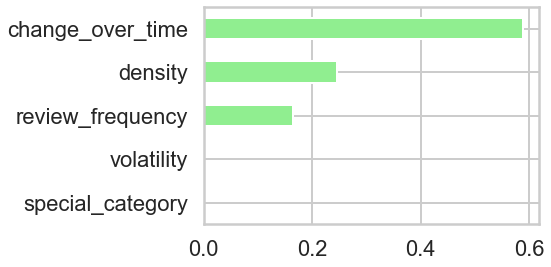

In [22]:
# Create series of the features importances and sort the values
importances = pd.Series(rf.feature_importances_, index=['special_category','change_over_time','density','volatility','review_frequency']).sort_values()

# Visualize the ranked importance of the features in a horizontal bar plot
importances.plot(kind='barh', color='lightgreen')
plt.show();

In [32]:
# Define the parameters grid of random forests
param_grid_rf = {'n_estimators': [100,200,300,400,500],
                 'max_depth': [2,3,4,5],
                 'min_samples_leaf': [0.1,0.2,1,2,3],
                 'max_features': [1,2,3,4,5]}

# Instantiate the GridSearchCV object
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)

# Fit to training data
grid_rf.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(grid_rf.best_params_))
print("Best score is {}".format(grid_rf.best_score_))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

Tuned Random Forest Parameters: {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 300}
Best score is 0.7678442682047585


In [33]:
# Extract the best random forest model from grid search
best_rf = grid_rf.best_estimator_

# Predict on test set
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the accuracy and MSE
accuracy_score(y_test, y_pred_best_rf)
MSE(y_test, y_pred_best_rf)

0.7628259041211102

0.23717409587888982

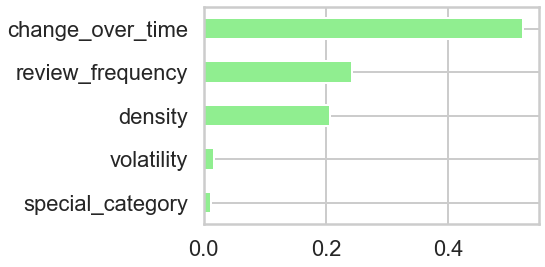

In [34]:
# Create series of the features importances and sort the values
importances = pd.Series(best_rf.feature_importances_, index=['special_category','change_over_time','density','volatility','review_frequency']).sort_values()

# Visualize the ranked importance of the features in a horizontal bar plot
importances.plot(kind='barh', color='lightgreen')
plt.show();

In [24]:
# Instantiate a decision tree classifier
dt_adb = DecisionTreeClassifier(max_depth = 3, max_features = 4, min_samples_leaf = 2, random_state=SEED)

# Instantiate a AdaBoost classifier
adb = AdaBoostClassifier(base_estimator=dt_adb, n_estimators=100)

# Fit AdaBoost to training data
adb.fit(X_train, y_train)

# Predict test set probabilities of restaurants that are open
y_pred_adb_proba = adb.predict_proba(X_test)[:,1]

# Evaluate the ROC area under the curve score
auc = roc_auc_score(y_test, y_pred_adb_proba)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=4,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=2,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=123,
                                 

In [25]:
auc

0.6549342179475494

In [28]:
# Instantiate Gradient Boosting classifier
gb = GradientBoostingClassifier(n_estimators=300, max_depth = 3, max_features = 4, min_samples_leaf = 2, random_state=SEED)

# Fit to training data
gb.fit(X_train, y_train)

# Predict the labels on test data
y_pred_gb = gb.predict(X_test)

# Evaluate the accuracy and MSE
accuracy_score(y_test, y_pred_gb)
MSE(y_test, y_pred_gb)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

0.7606181665264928

0.23938183347350714